In [2]:
pip install opencv--python ultralytics

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pillow

Note: you may need to restart the kernel to use updated packages.


In [4]:
import cv2 as cv
import os
import numpy as np
import time
import re
import warnings
import glob
from PIL import Image
import torch
import pandas as pd
import yaml
from tqdm import tqdm
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms as T
from torchinfo import summary
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline

In [5]:
root_folder="/kaggle/input/wider-face-a-face-detection-benchmark"
train_folder="/kaggle/input/wider-face-a-face-detection-benchmark/WIDER_train/WIDER_train/images"
val_folder="/kaggle/input/wider-face-a-face-detection-benchmark/WIDER_val/WIDER_val/images"
annotations_path="/kaggle/input/wider-face-a-face-detection-benchmark/wider_face_split"

In [6]:
img= Image.open("/kaggle/input/wider-face-a-face-detection-benchmark/WIDER_train/WIDER_train/images/0--Parade/0_Parade_Parade_0_110.jpg")

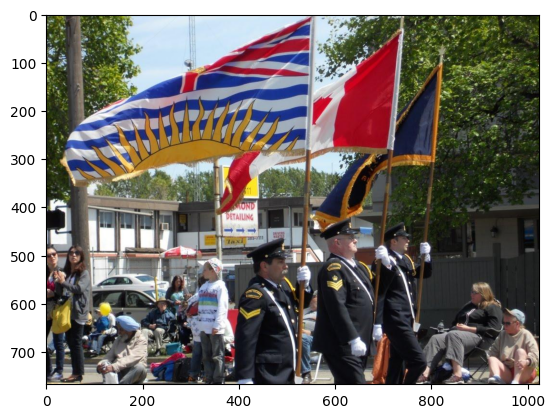

In [7]:
plt.imshow(img)

In [8]:
bbx_train_path="/kaggle/input/wider-face-a-face-detection-benchmark/wider_face_split/wider_face_split/wider_face_train_bbx_gt.txt"
bbx_val_path="/kaggle/input/wider-face-a-face-detection-benchmark/wider_face_split/wider_face_split/wider_face_val_bbx_gt.txt"

In [9]:
def load_bbx(bbx_path):
    """Loads bounding box annotations from a given file.

    Args:
        bbx_path (str): Path to the bounding box annotation file.

    Returns:
        dict: A dictionary where keys are image filenames and values are lists of bounding boxes.
    """
    annotations = {}

    try:
        with open(bbx_path, mode="r", encoding="utf-8", errors="ignore") as file:
            lines = file.readlines()
        
        i = 0
        while i < len(lines):
            file_name = lines[i].strip()
            i += 1
            if i >= len(lines):
                break
            
            try:
                num_boxes = int(lines[i].strip())
            except ValueError:
                print(f"Warning: Invalid number of boxes at line {i+1}")
                continue

            i += 1
            boxes = []
            
            for _ in range(num_boxes):
                if i >= len(lines):
                    break

                box_info = lines[i].strip().split()
                if len(box_info) < 4:
                    print(f"Warning: Skipping invalid box data at line {i+1}")
                    i += 1
                    continue
                
                box = {
                    "x": int(box_info[0]),
                    "y": int(box_info[1]),
                    "w": int(box_info[2]),
                    "h": int(box_info[3]),
                }
                boxes.append(box)
                i += 1
            
            annotations[file_name] = boxes
    
    except FileNotFoundError:
        print(f"Error: File '{bbx_path}' not found.")
    except Exception as e:
        print(f"Unexpected error: {e}")

    return annotations

In [10]:
train_annotations = load_bbx(bbx_train_path)
val_annotations = load_bbx(bbx_val_path)

In [11]:
train_keys = []
val_keys = []
for bbx_key in train_annotations.keys():
    train_keys.append(bbx_key)
for bbx_key in val_annotations.keys():
    val_keys.append(bbx_key)

In [12]:
len(train_keys), len(val_keys)

(12880, 3226)

In [13]:
def annotation_to_df(annotation, img_shape):
    if len(img_shape) < 2:
        raise ValueError("Invalid image shape. Must be (height, width, channels) or (height, width).")
    
    img_h, img_w = img_shape[:2]

    data = [
        (0, 
         (box["x"] + box["w"] / 2.0) / img_w,  
         (box["y"] + box["h"] / 2.0) / img_h,  
         box["w"] / img_w,                     
         box["h"] / img_h)                     
        for box in annotation
    ]

    return pd.DataFrame(data, columns=[0, 1, 2, 3, 4])

In [14]:
def plot_boxes(img, df):
    h, w, _ = img.shape
    
    fig, ax = plt.subplots()
    for index, row in df.iterrows():
        patch = Rectangle(
            ((row[1] - row[3] / 2.0) * w, (row[2] - row[4] / 2.0) * h),
            row[3] * w,
            row[4] * h,
            edgecolor = 'red',
            fill=False,
        )
        ax.add_patch(patch)
    
    plt.imshow(img)

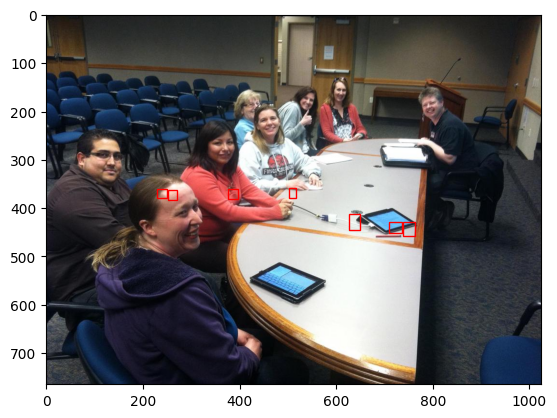

In [15]:
key = train_keys[random.randint(0, len(train_keys) - 1)]
img = np.array(Image.open("/kaggle/input/wider-face-a-face-detection-benchmark/WIDER_train/WIDER_train/images/11--Meeting/11_Meeting_Meeting_11_Meeting_Meeting_11_105.jpg"))
df = annotation_to_df(train_annotations[key], img.shape)
plot_boxes(img, df)

In [16]:
def add_dataset(keys, annotations, img_folder, root, split):
    # Ensure required directories exist
    img_split_path = os.path.join(root, "images", split)
    label_split_path = os.path.join(root, "labels", split)

    os.makedirs(img_split_path, exist_ok=True)
    os.makedirs(label_split_path, exist_ok=True)

    for i, key in enumerate(keys):
        img_path = os.path.join(img_folder, key)
        save_img_path = os.path.join(img_split_path, f"im{i}.jpg")
        save_label_path = os.path.join(label_split_path, f"im{i}.txt")

        try:
            # Load and save image
            img = np.array(Image.open(img_path))
            Image.fromarray(img).save(save_img_path)

            # Convert annotations to DataFrame and save labels
            df = annotation_to_df(annotations[key], img.shape)
            df.to_csv(save_label_path, header=False, index=False, sep='\t')

        except FileNotFoundError:
            print(f"Warning: Image '{img_path}' not found. Skipping.")
        except Exception as e:
            print(f"Error processing '{img_path}': {e}")

In [17]:
add_dataset(train_keys, train_annotations, train_folder, "/kaggle/working/datasets/faceset/", "train")
add_dataset(val_keys, val_annotations, val_folder, "/kaggle/working/datasets/faceset/", "val")

In [18]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -r "requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 17344, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 17344 (delta 24), reused 8 (delta 8), pack-reused 17311 (from 4)
Receiving objects: 100% (17344/17344), 16.23 MiB | 32.26 MiB/s, done.
Resolving deltas: 100% (11892/11892), done.
/kaggle/working/yolov5
/bin/bash: -c: line 1: unexpected EOF while looking for matching `"'
/bin/bash: -c: line 2: syntax error: unexpected end of file
Note: you may need to restart the kernel to use updated packages.


In [19]:
dataset_dict_file = {"path":"../datasets/faceset",
             "train":"images/train",
             "val":"images/val",
             "nc":0,
             "names": ["face"]}

with open("/kaggle/working/yolov5/data/dataset.yaml", 'w') as file:
    documents = yaml.dump(dataset_dict_file, file)

In [20]:
!python train.py --img 640 --epochs 12 --batch-size 32 --data dataset.yaml --weights yolov5s.pt

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-03-28 12:00:40.445220: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-28 12:00:40.641153: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-28 12:00:40.710491: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to regi

In [21]:
custom_yolov5 = torch.hub.load('/kaggle/working/yolov5', 'custom', path='runs/train/exp/weights/best.pt', force_reload=True, source='local')

YOLOv5 🚀 v7.0-409-ge9ab205e Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


/kaggle/working/yolov5/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


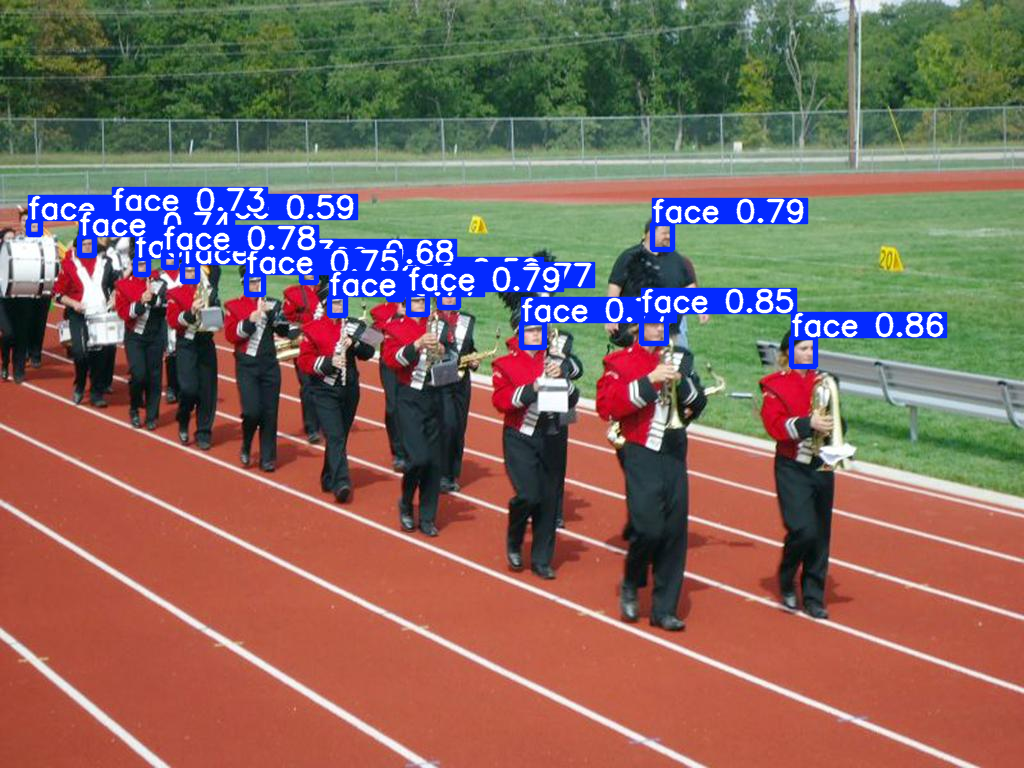

In [22]:
custom_yolov5.conf = 0.5
custom_yolov5.iou = 0.3
output = custom_yolov5(f"{train_folder}/{train_keys[2]}")
output.show()

/kaggle/working/yolov5/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


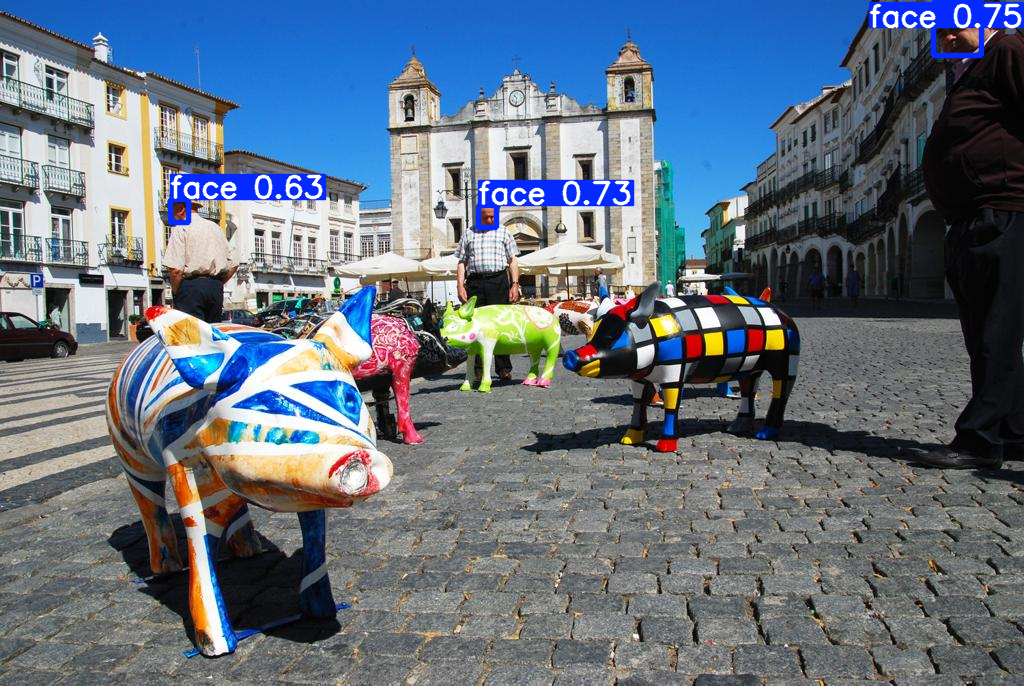

In [23]:
output = custom_yolov5(f"{train_folder}/{train_keys[27]}")
output.show()

/kaggle/working/yolov5/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


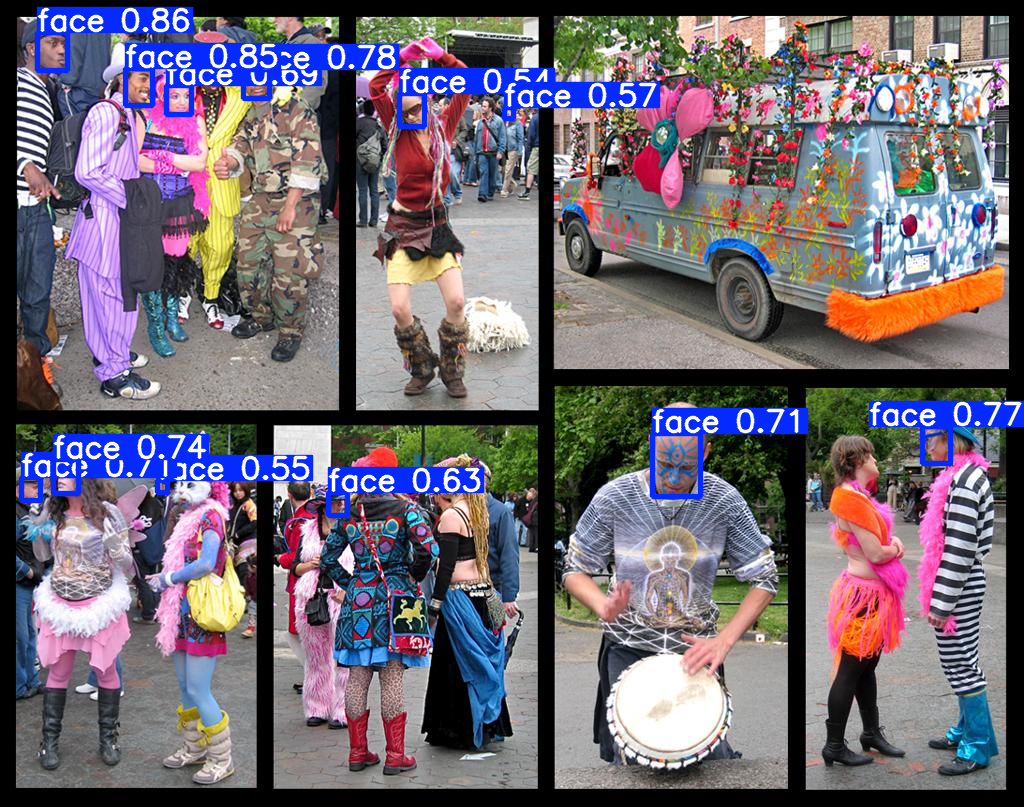

In [26]:
output = custom_yolov5(f"{train_folder}/{train_keys[14]}")
output.show()

/kaggle/working/yolov5/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


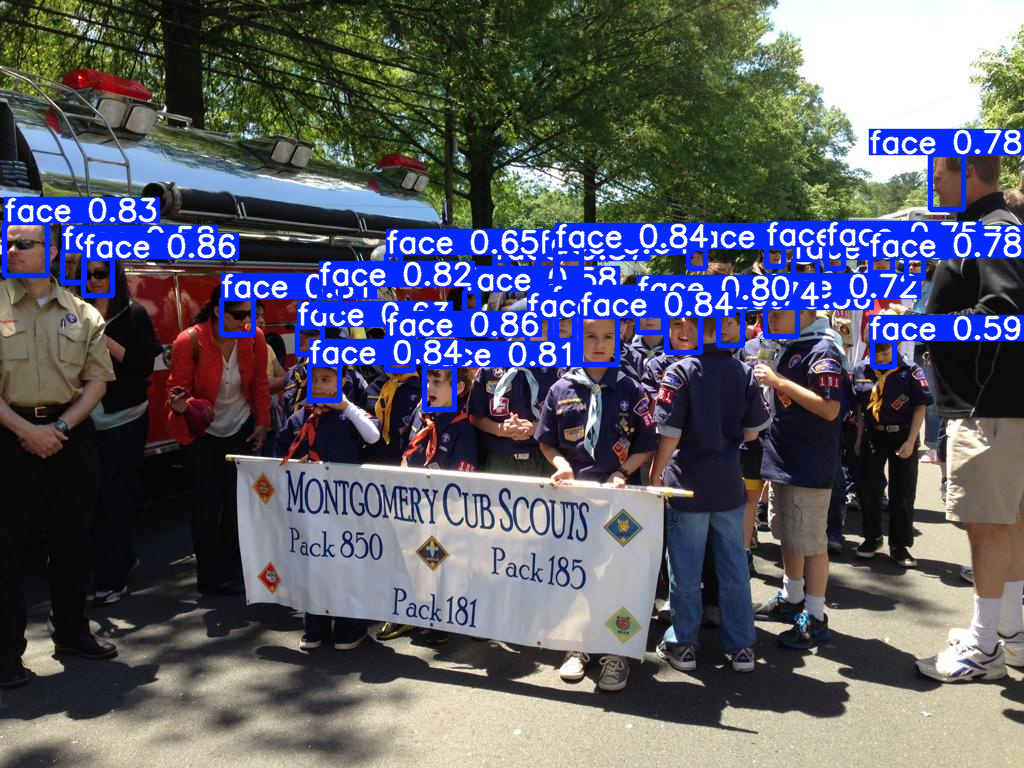

In [27]:
output = custom_yolov5(f"{train_folder}/{train_keys[49]}")
output.show()